# Model Evaluation: Regression & Classification

This notebook demonstrates **model evaluation** on a dataset of Swiss train stations, covering two scenarios:
1. **Regression** (predicting a numeric target, e.g., `DTV`)
2. **Classification** (predicting a binary label, e.g., High vs. Low traffic)

We will use **scikit-learn** metrics:
- **Regression**: R², MAE, RMSE
- **Classification**: Accuracy, Precision, Recall, F1, Confusion Matrix

## Contents
1. **Setup** (imports)
2. **Data Loading & Preparation**
3. **Regression** Example
4. **Classification** Example
5. **Summary & Next Steps**


In [1]:
# 1) Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, mean_absolute_error, mean_squared_error,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix
)

# Optional: for inline plotting in Jupyter
%matplotlib inline

## 2. Data Loading & Preparation
We assume you have a CSV named `stations.csv` containing columns like:
- `DTV`, `DWV`, `DNWV` (numeric)
- `Kanton`, `EVU` (categorical)
- `lon`, `lat` (numeric)
… and more.

### 2.1 Load Data & Basic Cleaning

In [2]:
# Load your CSV file
df = pd.read_csv("data_prepared.csv")  # change if needed
print("Data shape:", df.shape)
df.head()

Data shape: (3470, 12)


,Code,UIC,Bahnhof,Kanton,ISB_GI,Jahr,DTV,DWV,DNWV,EVU,lon,lat
0,AAT,8503124,Aathal,ZH,SBB,2018,740,800,610,SBB,8.765625,47.335959
1,AB,8507472,Ausserberg,VS,BLS,2018,180,160,210,BLS,7.844167,46.312348
2,ABE,8504404,Aarberg,BE,SBB,2022,520,580,400,BLS,7.278693,47.044541
3,ABE,8504404,Aarberg,BE,SBB,2023,580,620,460,BLS,7.278693,47.044541
4,ABO,8502000,Aarburg-Oftringen,AG,SBB,2022,2500,2900,1500,SBB,7.908223,47.320268


### 2.2 Drop Missing or Invalid Rows
We'll keep only rows where `DTV`, `DWV`, `DNWV`, `Kanton`, `EVU`, `lon`, `lat` are valid.

In [3]:
required_cols = ['DTV','DWV','DNWV','Kanton','EVU','lon','lat']
df.dropna(subset=required_cols, inplace=True)

# Convert numeric columns
num_cols = ['DTV','DWV','DNWV','lon','lat']
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

df.dropna(subset=num_cols, inplace=True)
print("Data shape after cleaning:", df.shape)

Data shape after cleaning: (3470, 12)


### 2.3 Encode Categorical Features
We do one-hot encoding for `Kanton` and `EVU` so we can use them in scikit-learn.

In [4]:
df_encoded = pd.get_dummies(df, columns=['Kanton','EVU'], drop_first=True)
print("Encoded shape:", df_encoded.shape)
df_encoded.head()

Encoded shape: (3470, 89)


,Code,UIC,Bahnhof,ISB_GI,Jahr,DTV,DWV,DNWV,lon,lat,...,"EVU_SBB, TPF","EVU_SBB, TRAVYS","EVU_SBB, Thurbo","EVU_SBB, Trenord","EVU_SBB, transN",EVU_SOB,"EVU_SOB, Thurbo",EVU_TRAVYS,EVU_Thurbo,EVU_Zentralbahn
0,AAT,8503124,Aathal,SBB,2018,740,800,610,8.765625,47.335959,...,False,False,False,False,False,False,False,False,False,False
1,AB,8507472,Ausserberg,BLS,2018,180,160,210,7.844167,46.312348,...,False,False,False,False,False,False,False,False,False,False
2,ABE,8504404,Aarberg,SBB,2022,520,580,400,7.278693,47.044541,...,False,False,False,False,False,False,False,False,False,False
3,ABE,8504404,Aarberg,SBB,2023,580,620,460,7.278693,47.044541,...,False,False,False,False,False,False,False,False,False,False
4,ABO,8502000,Aarburg-Oftringen,SBB,2022,2500,2900,1500,7.908223,47.320268,...,False,False,False,False,False,False,False,False,False,False


## 3. Regression Example
We’ll predict the **numeric** target `DTV` from the available features. For simplicity, we’ll consider:
- `DWV`, `DNWV`, `lon`, `lat` + one-hot columns for `Kanton` and `EVU`

### 3.1 Train/Test Split
We'll do a standard 80/20 split.

In [5]:
target_col = 'DTV'
exclude_cols = ['Code','UIC','Bahnhof','ISB_GI','Jahr','DTV']

X_cols = [c for c in df_encoded.columns if c not in exclude_cols]
X = df_encoded[X_cols].values
y = df_encoded[target_col].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train set shape:", X_train.shape, y_train.shape)
print("Test  set shape:", X_test.shape,  y_test.shape)

Train set shape: (2776, 83) (2776,)
Test  set shape: (694, 83) (694,)


### 3.2 Fit a Linear Regression

In [6]:
reg_model = LinearRegression()
reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
print("Model trained.")

Model trained.


### 3.3 Evaluate Regression
- **R²** (coefficient of determination)
- **MAE** (mean absolute error)
- **RMSE** (root mean squared error)

In [7]:
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Calculate RMSE manually

print("Regression Metrics:")
print(f"  R^2   = {r2:.3f}")
print(f"  MAE   = {mae:.2f}")
print(f"  RMSE  = {rmse:.2f}")

Regression Metrics:
  R^2   = 1.000
  MAE   = 15.72
  RMSE  = 28.48


### 3.4 Visualize Predicted vs Actual

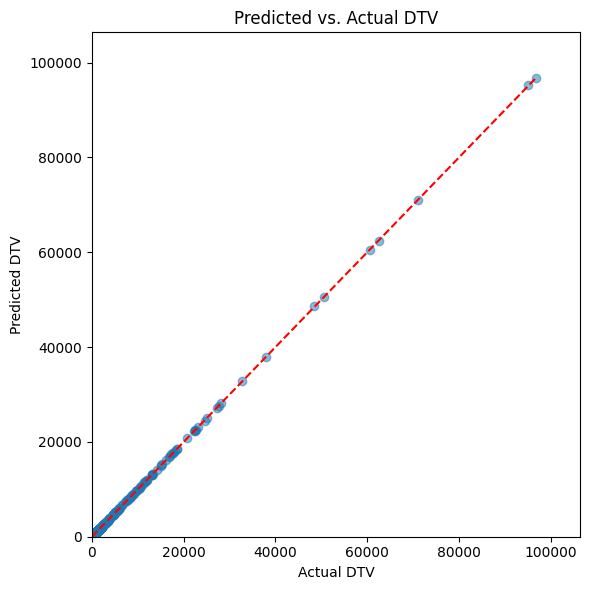

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([0, max(y_test)], [0, max(y_test)], '--r')
plt.title("Predicted vs. Actual DTV")
plt.xlabel("Actual DTV")
plt.ylabel("Predicted DTV")
plt.xlim([0, max(y_test)*1.1])
plt.ylim([0, max(y_pred)*1.1])
plt.tight_layout()
plt.show()

## 4. Classification Example
We'll create a **binary** target for “High Traffic” vs “Low Traffic,” e.g. stations with `DTV >= 1000` are **1** (high) else **0** (low).

Then we use **Logistic Regression** (as a simple classifier) and evaluate with:
- Accuracy
- Precision
- Recall
- F1 score
- Confusion matrix

In [9]:
# Create binary target
df_encoded['HighTraffic'] = (df_encoded['DTV'] >= 1000).astype(int)

# We'll predict HighTraffic from the same set of features,
# but exclude DTV itself.
exclude_cols_clf = ['HighTraffic','DTV','Code','UIC','Bahnhof','ISB_GI','Jahr']
X_cols_clf = [c for c in df_encoded.columns if c not in exclude_cols_clf]
X_clf = df_encoded[X_cols_clf].values
y_clf = df_encoded['HighTraffic'].values

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42
)

clf_model = LogisticRegression(max_iter=1000)
clf_model.fit(X_train_clf, y_train_clf)

# Predict on test set
y_pred_clf = clf_model.predict(X_test_clf)

print("Classification model trained.")

Classification model trained.


### 4.1 Evaluate Classification
- **Accuracy**: overall fraction of correct predictions
- **Precision**: fraction of predicted positives that are correct
- **Recall**: fraction of actual positives that are identified
- **F1**: harmonic mean of precision and recall

Finally, we plot the **confusion matrix** as a heatmap.

Classification Metrics:
  Accuracy  = 0.993
  Precision = 0.992
  Recall    = 0.988
  F1 Score  = 0.990

Confusion Matrix:
[[434   2]
 [  3 255]]


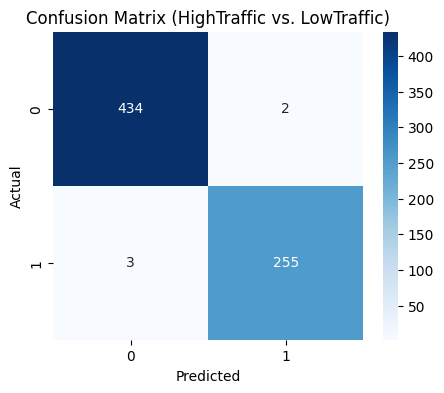

In [10]:
acc = accuracy_score(y_test_clf, y_pred_clf)
prec = precision_score(y_test_clf, y_pred_clf, zero_division=0)
rec = recall_score(y_test_clf, y_pred_clf, zero_division=0)
f1 = f1_score(y_test_clf, y_pred_clf, zero_division=0)

print("Classification Metrics:")
print(f"  Accuracy  = {acc:.3f}")
print(f"  Precision = {prec:.3f}")
print(f"  Recall    = {rec:.3f}")
print(f"  F1 Score  = {f1:.3f}")

cm = confusion_matrix(y_test_clf, y_pred_clf)
print("\nConfusion Matrix:")
print(cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (HighTraffic vs. LowTraffic)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## 5. Summary & Next Steps

1. **Regression**
   - We used **LinearRegression** to predict `DTV`.
   - Evaluated with **R²**, **MAE**, **RMSE**, and a scatter plot.

2. **Classification**
   - We defined a binary label `HighTraffic`.
   - Used **LogisticRegression** to classify stations.
   - Evaluated with **accuracy**, **precision**, **recall**, **F1**, and a confusion matrix.

### Possible Enhancements
- **Cross-validation**: More robust performance estimates.
- **Hyperparameter tuning**: `GridSearchCV` or `RandomizedSearchCV`.
- **Alternative models**: Random Forest, Gradient Boosting, etc.
- **Feature engineering**: More meaningful transformations of `DWV`, `DNWV`, location-based features, etc.
- **Handling skew**: Log-transform `DTV` or set thresholds carefully.

This completes our **model evaluation** demo!